# Solving a New Keynesian model with Python

This file is part of a computational appendix that accompanies the paper.

> MATLAB, Python, Julia: What to Choose in Economics?
>
> Coleman, Lyon, Maliar, and Maliar (2017)

In order to run the codes in this file you will need to install and
configure a few Python packages. We recommend following the instructions
on
[quantecon.org](https://lectures.quantecon.org/jl/getting_started.html)
for getting a base python installation set up. Then to acquire
additional packages used in this file, uncomment the lines in the
cell below (delete the `#` and space at the beginning of the line) and
then run the cell:

For some details regarding the model solved in this file, please see
the [companion notebook that describes the model](http://bookshelf.quant
econ.org/submission/59fa1b45145fc3772b0cef82).

In [1]:
# !pip install git+https://github.com/EconForge/interpolation.py.git
# !pip install git+https://github.com/naught101/sobol_seq.git
# !pip install requests

## Python Code

The Python version of our algorithm is implemented as a few methods defined on
a core class named `Model`. This class is itself composed of instances of three
different classes that hold the model parameters, steady state, and grids
needed to describe the numerical model. Before we get to the classes, we need
to bring in some dependencies:

In [2]:
import os
import sys
import math
from math import sqrt
import time as time
from collections import namedtuple
import requests

if "table" not in sys.argv:
    import matplotlib.pyplot as plt
    # turn on interactive mode so plots display automatically
    plt.ion()

import numpy as np
from numpy import exp
from scipy.io import loadmat
from interpolation.complete_poly import (_complete_poly_impl_vec,
                                         _complete_poly_impl,
                                         complete_polynomial)
import sobol_seq

# get path to this folder
DIR = os.path.abspath("")

# set seed on random number generator to make results reproducible
np.random.seed(42)

We will also need the following two functions, which use monomial rules to
compute quadrature nodes and weights:

In [3]:
def qnwmonomial1(vcv):
    n = vcv.shape[0]
    n_nodes = 2*n

    z1 = np.zeros((n_nodes, n))

    # In each node, random variable i takes value either 1 or -1, and
    # all other variables take value 0. For example, for N = 2,
    # z1 = [1 0; -1 0; 0 1; 0 -1]
    for i in range(n):
        z1[2*i:2*(i+1), i] = [1, -1]

    sqrt_vcv = np.linalg.cholesky(vcv)
    R = np.sqrt(n)*sqrt_vcv
    ϵj = z1 @ R
    ωj = np.ones(n_nodes) / n_nodes

    return ϵj, ωj


def qnwmonomial2(vcv):
    n = vcv.shape[0]
    assert n == vcv.shape[1], "Variance covariance matrix must be square"
    z0 = np.zeros((1, n))

    z1 = np.zeros((2*n, n))
    # In each node, random variable i takes value either 1 or -1, and
    # all other variables take value 0. For example, for N = 2,
    # z1 = [1 0; -1 0; 0 1; 0 -1]
    for i in range(n):
        z1[2*i:2*(i+1), i] = [1, -1]

    z2 = np.zeros((2*n*(n-1), n))
    i = 0

    # In each node, a pair of random variables (p,q) takes either values
    # (1,1) or (1,-1) or (-1,1) or (-1,-1), and all other variables take
    # value 0. For example, for N = 2, `z2 = [1 1; 1 -1; -1 1; -1 1]`
    for p in range(n-1):
        for q in range(p+1, n):
            z2[4*i:4*(i+1), p] = [1, -1, 1, -1]
            z2[4*i:4*(i+1), q] = [1, 1, -1, -1]
            i += 1

    sqrt_vcv = np.linalg.cholesky(vcv)
    R = np.sqrt(n+2)*sqrt_vcv
    S = np.sqrt((n+2)/2)*sqrt_vcv
    ϵj = np.row_stack([z0, z1 @ R, z2 @ S])

    ωj = np.concatenate([2/(n+2) * np.ones(z0.shape[0]),
                         (4-n)/(2*(n+2)**2) * np.ones(z1.shape[0]),
                         1/(n+2)**2 * np.ones(z2.shape[0])])
    return ϵj, ωj

## Classes

First we have the `Params` class, which holds all the model parameters as well
as the paramters that drive the algorithm.

In [4]:
SteadyState = namedtuple("SteadyState",
                         ["Yn", "Y", "π", "δ", "L", "C", "F", "S", "R", "w"])


class Params(object):
    def __init__(self, zlb=True, γ=1, β=0.99, ϑ=2.09, ϵ=4.45, ϕ_y=0.07,
                 ϕ_π=2.21, μ=0.82, Θ=0.83, πstar=1, gbar=0.23,
                 ρηR=0.0, ρηa=0.95, ρηL=0.25, ρηu=0.92, ρηB=0.0, ρηG=0.95,
                 σηR=0.0028, σηa=0.0045, σηL=0.0500, σηu=0.0054, σηB=0.0010,
                 σηG=0.0038, degree=2):

        self.zlb = zlb      # whether or not the zlb should be imposed
        self.γ = γ          # Utility-function parameter
        self.β = β          # Discount factor
        self.ϑ = ϑ          # Utility-function parameter
        self.ϵ = ϵ          # Parameter in the Dixit-Stiglitz aggregator
        self.ϕ_y = ϕ_y      # Parameter of the Taylor rule
        self.ϕ_π = ϕ_π      # Parameter of the Taylor rule
        self.μ = μ          # Parameter of the Taylor rule
        self.Θ = Θ          # Share of non-reoptimizing firms (Calvo's pricing)
        self.πstar = πstar  # Target (gross) inflation rate
        self.gbar = gbar    # Steady-state share of gov. spending in output

        # autocorrelation coefficients
        self.ρηR = ρηR  # See process (28) in MM (2015)
        self.ρηa = ρηa  # See process (22) in MM (2015)
        self.ρηL = ρηL  # See process (16) in MM (2015)
        self.ρηu = ρηu  # See process (15) in MM (2015)
        self.ρηB = ρηB  # See process (17) in MM (2015)
        self.ρηG = ρηG  # See process (26) in MM (2015)

        # standard deviations
        self.σηR = σηR  # See process (28) in MM (2015)
        self.σηa = σηa  # See process (22) in MM (2015)
        self.σηL = σηL  # See process (16) in MM (2015)
        self.σηu = σηu  # See process (15) in MM (2015)
        self.σηB = σηB  # See process (17) in MM (2015)
        self.σηG = σηG  # See process (26) in MM (2015)

        self.degree = degree

    @property
    def vcov(self):
        return np.diag([self.σηR**2, self.σηa**2, self.σηL**2,
                        self.σηu**2, self.σηB**2, self.σηG**2])

    @property
    def steady_state(self):
        Yn_ss = exp(self.gbar)**(self.γ/(self.ϑ+self.γ))
        Y_ss = Yn_ss
        π_ss = 1.0
        δ_ss = 1.0
        L_ss = Y_ss/δ_ss
        C_ss = (1-self.gbar)*Y_ss
        F_ss = C_ss**(-self.γ)*Y_ss/(1-self.β*self.Θ*π_ss**(self.ϵ-1))
        S_ss = L_ss**self.ϑ*Y_ss/(1-self.β*self.Θ*π_ss**self.ϵ)
        R_ss = π_ss/self.β
        w_ss = (L_ss**self.ϑ)*(C_ss**self.γ)

        return SteadyState(
            Yn_ss, Y_ss, π_ss, δ_ss, L_ss, C_ss, F_ss, S_ss, R_ss, w_ss
        )

    @property
    def grid_size(self):
        "Grid size pinned down by degree of polynomials"
        return {1: 20, 2: 100, 3: 300, 4: 1000, 5: 2000}[self.degree]

Notice that we have a namedtuple to hold the steady state of the model. Using
the namedtuple infrastructure allows us to have convenient "dot-style" access
to the steady state, without defining a full class.

Given an instance of `Params` class, we can construct the grid on which we will
solve the model.

The `Grids` class holds this grid as well as matrices used to compute
expectations.

To match the Julia and Matlab versions of the code, the `__init__` method for
`Grids` below loads pre-generated grids from a `.mat` file for both Sobol and
random grids. This ensures that the exact same code is run in each language. If
you would like to generate the grids in pure Python, you can set the
`grid_source` keyword argument to `"python"`

In [5]:
class Grids(object):

    def __init__(self, p, kind="random", grid_source="mat"):
        m = p.grid_size
        σ = np.array([p.σηR, p.σηa, p.σηL, p.σηu, p.σηB, p.σηG])
        ρ = np.array([p.ρηR, p.ρηa, p.ρηL, p.ρηu, p.ρηB, p.ρηG])

        if kind == "sobol":
            if grid_source == "mat":
                _path = os.path.join(DIR, "Sobol_grids.mat")
                s = loadmat(_path)["Sobol_grids"][:m, :]
            else:
                s = sobol_seq.i4_sobol_generate(8, m)
            sη = s[:, :6]
            η = (-2*σ + 4*(sη.max(0)-sη) / (sη.max(0)-sη.min(0))*σ)/np.sqrt(1-ρ**2)
            R = 1+0.05*(np.max(s[:, 6])-s[:, 6])/(np.max(s[:, 6])-np.min(s[:, 6]))
            δ = 0.95+0.05*(np.max(s[:, 7])-s[:, 7])/(np.max(s[:, 7])-np.min(s[:, 7]))
        else:
            # Values of exogenous state variables are distributed uniformly
            # in the interval +/- std/sqrt(1-rho_nu**2)
            if grid_source == "mat":
                _path = os.path.join(DIR, "random_grids.mat")
                s = loadmat(_path)["random_grids"][:m, :]
            else:
                s = np.random.rand(m, 8)
            sη = s[:, :6]
            η = (-2*σ + 4*σ*sη) / np.sqrt(1-ρ**2)

            # Values of endogenous state variables are distributed uniformly
            # in the intervals [1 1.05] and [0.95 1], respectively
            R = 1 + 0.05 * s[:, 6]
            δ = 0.95 + 0.05 * s[:, 7]

        ηR = η[:, 0]
        ηa = η[:, 1]
        ηL = η[:, 2]
        ηu = η[:, 3]
        ηB = η[:, 4]
        ηG = η[:, 5]

        self.ηR = ηR
        self.ηa = ηa
        self.ηL = ηL
        self.ηu = ηu
        self.ηB = ηB
        self.ηG = ηG
        self.R = R
        self.δ = δ

        # shape (8, m)
        self.X = np.vstack([np.log(R), np.log(δ), η.T])

        # shape (n_complete(8, p.Degree), m)
        self.X0_G = {
            1: complete_polynomial(self.X, 1),
            p.degree: complete_polynomial(self.X, p.degree)
        }

        # shape (2*n=12, n=6)
        self.ϵ_nodes, self.ω_nodes = qnwmonomial1(p.vcov)

        # all shape (len(ϵ_nodes), m)
        self.ηR1 = p.ρηR * ηR[None, :] + self.ϵ_nodes[:, None, 0]
        self.ηa1 = p.ρηa * ηa[None, :] + self.ϵ_nodes[:, None, 1]
        self.ηL1 = p.ρηL * ηL[None, :] + self.ϵ_nodes[:, None, 2]
        self.ηu1 = p.ρηu * ηu[None, :] + self.ϵ_nodes[:, None, 3]
        self.ηB1 = p.ρηB * ηB[None, :] + self.ϵ_nodes[:, None, 4]
        self.ηG1 = p.ρηG * ηG[None, :] + self.ϵ_nodes[:, None, 5]

Finally, we construct the Model class, which has an instance of Params,
SteadyState and Grids as its three attributes.

This block of code will be longer than the others because we also include
routines to solve and simulate the model as methods on the Model class. These
methods will be clearly marked and commented.

In [6]:
class Model(object):
    def __init__(self, p=Params(), g=None):
        if g is None:
            g = Grids(p)

        self.p = p
        self.g = g
        self.s = self.p.steady_state

    def init_coefs(self, degree):
        "Iniital guess for coefs. We evaluate interpoland as coefs @ basis_mat"
        npol = self.g.X0_G[degree].shape[0]
        coefs = np.full((3, npol), 1e-5)
        coefs[:, 0] = [self.s.S, self.s.F, self.s.C**(-self.p.γ)]
        return coefs

    def step(self, S, F, C, δ0, R0, ηG, ηa, ηL, ηR):
        # simplify notation
        Θ, ϵ, gbar, ϑ, γ = self.p.Θ, self.p.ϵ, self.p.gbar, self.p.ϑ, self.p.γ
        β, μ, ϕ_π, ϕ_y = self.p.β, self.p.μ, self.p.ϕ_π, self.p.ϕ_y
        πstar = self.p.πstar

        # Compute pie(t) from condition (35) in MM (2015)
        π0 = ((1-(1-Θ)*(S/F)**(1-ϵ))/Θ)**(1/(ϵ-1))

        # Compute delta(t) from condition (36) in MM (2015)
        δ1 = ((1-Θ)*((1-Θ*π0**(ϵ-1))/(1-Θ))**(ϵ/(ϵ-1))+Θ*π0**ϵ/δ0)**(-1)

        # Compute Y(t) from condition (38) in MM (2015)
        Y0 = C/(1-gbar/exp(ηG))

        # Compute L(t) from condition (37) in MM (2015)
        L0 = Y0/exp(ηa)/δ1

        #  Compute Yn(t) from condition (31) in MM (2015)
        Yn0 = (exp(ηa)**(1+ϑ)*(1-gbar/exp(ηG))**(-γ)/exp(ηL))**(1/(ϑ+γ))

        # Compute R(t) from conditions (27), (39) in MM (2015) -- Taylor rule
        R1 = πstar/β*(R0*β/πstar)**μ*((π0/πstar)**ϕ_π * (Y0/Yn0)**ϕ_y)**(1-μ)*exp(ηR)

        return π0, δ1, Y0, L0, Yn0, R1

    def solve(self, damp=0.1, tol=1e-7, verbose=False):
        # rename self to m to make code below readable
        m = self

        n = len(m.g.ηR)
        n_nodes = len(m.g.ω_nodes)

        ## allocate memory
        # euler equations
        e = np.zeros((3, n))

        # previous iteration S, F, C
        S0_old_G = np.ones(n)
        F0_old_G = np.ones(n)
        C0_old_G = np.ones(n)

        # current iteration S, F, C
        S0_new_G = np.ones(n)
        F0_new_G = np.ones(n)
        C0_new_G = np.ones(n)

        # future S, F, C
        S1 = np.zeros((n_nodes, n))
        F1 = np.zeros((n_nodes, n))
        C1 = np.zeros((n_nodes, n))

        degs = [self.p.degree] if self.p.degree == 1 else [1, self.p.degree]

        for deg in degs:
            # housekeeping
            err = 1.0
            it = 0
            X0_G = m.g.X0_G[deg]

            start_time = time.time()

            if deg <= 2:
                coefs = self.init_coefs(deg)
            else:
                coefs = np.linalg.lstsq(X0_G.T, e.T)[0].T
                # old_coefs = coefs.copy()
                # coefs = self.init_coefs(deg)
                # coefs[:, :old_coefs.shape[1]] = old_coefs

            while err > tol:
                it += 1
                # Current choices (at t)
                # ------------------------------
                SFC0 = coefs @ X0_G
                S0 = SFC0[0, :]                # Compute S(t) using coefs
                F0 = SFC0[1, :]                # Compute F(t) using coefs
                C0 = (SFC0[2, :])**(-1/m.p.γ)  # Compute C(t) using coefs
                π0, δ1, Y0, L0, Yn0, R1 = self.step(
                    S0, F0, C0, m.g.δ, m.g.R, m.g.ηG, m.g.ηa, m.g.ηL, m.g.ηR
                )

                if self.p.zlb:
                    R1 = np.maximum(R1, 1.0)

                for u in range(n_nodes):
                    # Form complete polynomial of degree "Degree" (at t+1 states)
                    grid1 = [np.log(R1), np.log(δ1), m.g.ηR1[u, :], m.g.ηa1[u, :],
                             m.g.ηL1[u, :], m.g.ηu1[u, :], m.g.ηB1[u, :], m.g.ηG1[u, :]]

                    X1 = complete_polynomial(grid1, deg)

                    S1[u, :] = coefs[0, :] @ X1                # Compute S(t+1)
                    F1[u, :] = coefs[1, :] @ X1                # Compute F(t+1)
                    C1[u, :] = (coefs[2, :] @ X1)**(-1/m.p.γ)  # Compute C(t+1)

                # Compute next-period π using condition
                # (35) in MM (2015)
                π1 = ((1-(1-m.p.Θ)*(S1/F1)**(1-m.p.ϵ))/m.p.Θ)**(1/(m.p.ϵ-1))

                # Evaluate conditional expectations in the Euler equations
                #---------------------------------------------------------
                e[0, :] = exp(m.g.ηu)*exp(m.g.ηL)*L0**m.p.ϑ*Y0/exp(m.g.ηa) + m.g.ω_nodes @ (m.p.β*m.p.Θ*π1**m.p.ϵ*S1)
                e[1, :] = exp(m.g.ηu)*C0**(-m.p.γ)*Y0 + m.g.ω_nodes @ (m.p.β*m.p.Θ*π1**(m.p.ϵ-1)*F1)
                e[2, :] = m.p.β*exp(m.g.ηB)/exp(m.g.ηu)*R1 * (m.g.ω_nodes @ ((exp(m.g.ηu1)*C1**(-m.p.γ)/π1)))

                # Variables of the current iteration
                #-----------------------------------
                np.copyto(S0_new_G, S0)
                np.copyto(F0_new_G, F0)
                np.copyto(C0_new_G, C0)

                # Compute and update the coefficients of the decision functions
                # -------------------------------------------------------------
                coefs_hat = np.linalg.lstsq(X0_G.T, e.T)[0].T

                # Update the coefficients using damping
                coefs = damp*coefs_hat + (1-damp)*coefs

                # Evaluate the percentage (unit-free) difference between the values
                # on the grid from the previous and current iterations
                # -----------------------------------------------------------------
                # The convergence criterion is adjusted to the damping parameters
                err = (np.mean(np.abs(1-S0_new_G/S0_old_G)) +
                       np.mean(np.abs(1-F0_new_G/F0_old_G)) +
                       np.mean(np.abs(1-C0_new_G/C0_old_G)))

                # Store the obtained values for S(t), F(t), C(t) on the grid to
                # be used on the subsequent iteration in Section 10.2.6
                #-----------------------------------------------------------------------
                np.copyto(S0_old_G, S0_new_G)
                np.copyto(F0_old_G, F0_new_G)
                np.copyto(C0_old_G, C0_new_G)

                if it % 20 == 0 and verbose:
                    print("On iteration {:d} err is {:6.7e}".format(it, err))

        elapsed = time.time() - start_time

        return coefs, elapsed

    def simulate(self, coefs=None, capT=10201):
        if coefs is None:
            coefs, elapsed = self.solve()

        # rename self to m to make code below readable
        m = self

        # create namedtuple to hold simulation results in an organized container
        Simulation = namedtuple(
            "Simulation",
            ["nuR", "nua", "nuL", "nuu", "nuB", "nuG",
             "δ", "R", "S", "F", "C", "π", "Y", "L", "Yn", "w"]
        )

        # 11. Simualating a time-series solution
        #---------------------------------------

        # Initialize the values of 6 exogenous shocks and draw innovations
        #-----------------------------------------------------------------
        nuR = np.zeros(capT)
        nua = np.zeros(capT)
        nuL = np.zeros(capT)
        nuu = np.zeros(capT)
        nuB = np.zeros(capT)
        nuG = np.zeros(capT)

        # Generate the series for shocks
        #-------------------------------
        _path = os.path.join(DIR, "epsi_test_NK.mat")
        rands = (loadmat(_path)["epsi_test_NK"])
        capT = rands.shape[0]
        # rands = np.random.randn(capT-1, 6)

        for t in range(capT-1):
            nuR[t+1] = self.p.ρηR*nuR[t] + self.p.σηR*rands[t, 0]
            nua[t+1] = self.p.ρηa*nua[t] + self.p.σηa*rands[t, 1]
            nuL[t+1] = self.p.ρηL*nuL[t] + self.p.σηL*rands[t, 2]
            nuu[t+1] = self.p.ρηu*nuu[t] + self.p.σηu*rands[t, 3]
            nuB[t+1] = self.p.ρηB*nuB[t] + self.p.σηB*rands[t, 4]
            nuG[t+1] = self.p.ρηG*nuG[t] + self.p.σηG*rands[t, 5]

        # Allocate memory for time series of ...
        δ = np.ones(capT+1)  # ... delta(t)
        R = np.ones(capT+1)  # ... R(t)
        S = np.ones(capT)    # ... S(t)
        F = np.ones(capT)    # ... F(t)
        C = np.ones(capT)    # ... C(t)
        π = np.ones(capT)    # ... π(t)
        Y = np.ones(capT)    # ... Y(t)
        L = np.ones(capT)    # ... L(t)
        Yn = np.ones(capT)   # ... Yn(t)
        w = np.ones(capT)    # ... w(t)

        pol_bases = np.empty(coefs.shape[1])
        states = np.empty(8)

        for t in range(capT):
            states[0] = math.log(R[t])
            states[1] = math.log(δ[t])
            states[2] = nuR[t]
            states[3] = nua[t]
            states[4] = nuL[t]
            states[5] = nuu[t]
            states[6] = nuB[t]
            states[7] = nuG[t]

            _complete_poly_impl_vec(states, self.p.degree, pol_bases)

            vals = coefs @ pol_bases
            S[t] = vals[0]
            F[t] = vals[1]
            C[t] = (vals[2])**(-1/m.p.γ)

            π[t], δ[t+1], Y[t], L[t], Yn[t], R[t+1] = self.step(
                S[t], F[t], C[t], δ[t], R[t], nuG[t], nua[t], nuL[t], nuR[t]
            )

            # Compute real wage
            w[t] = exp(nuL[t])*(L[t]**m.p.ϑ)*(C[t]**m.p.γ)

            # If ZLB is imposed, set R(t)=1 if ZLB binds
            if self.p.zlb:
                R[t+1] = max(R[t+1], 1.0)

        return Simulation(nuR, nua, nuL, nuu, nuB, nuG, δ, R, S, F, C, π, Y, L, Yn, w)

    def residuals(self, coefs, sim, burn=200):
        m = self  # rename self to m so the rest of this code is more readable
        capT = len(sim.w)
        resids = np.zeros((capT, 9))

        # Integration method for evaluating accuracy
        # ------------------------------------------
        # Monomial integration rule with 2N**2+1 nodes
        ϵ_nodes, ω_nodes = qnwmonomial2(m.p.vcov)
        n_nodes = len(ω_nodes)

        # Allocate for arrays needed in the loop
        basis_mat = np.empty((8, n_nodes))
        X1 = np.empty((coefs.shape[1], n_nodes))

        nuR1 = np.empty(n_nodes)
        nua1 = np.empty(n_nodes)
        nuL1 = np.empty(n_nodes)
        nuu1 = np.empty(n_nodes)
        nuB1 = np.empty(n_nodes)
        nuG1 = np.empty(n_nodes)

        for t in range(capT):                 # For each given point,
            # Take the corresponding value for shocks at t
            #---------------------------------------------
            nuR0 = sim.nuR[t]  # nuR(t)
            nua0 = sim.nua[t]  # nua(t)
            nuL0 = sim.nuL[t]  # nuL(t)
            nuu0 = sim.nuu[t]  # nuu(t)
            nuB0 = sim.nuB[t]  # nuB(t)
            nuG0 = sim.nuG[t]  # nuG(t)

            # Exctract time t values for all other variables (and t+1 for R, δ)
            #------------------------------------------------------------------
            R0 = sim.R[t]    # R(t-1)
            δ0 = sim.δ[t]    # δ(t-1)
            R1 = sim.R[t+1]  # R(t)
            δ1 = sim.δ[t+1]  # δ(t)

            L0 = sim.L[t]    # L(t)
            Y0 = sim.Y[t]    # Y(t)
            Yn0 = sim.Yn[t]  # Yn(t)
            π0 = sim.π[t]    # π(t)
            S0 = sim.S[t]    # S(t)
            F0 = sim.F[t]    # F(t)
            C0 = sim.C[t]    # C(t)

            # Fill basis matrix with R1, δ1 and shocks
            #-----------------------------------------
            # Note that we do not premultiply by standard deviations as ϵ_nodes
            # already include them. All these variables are vectors of length n_nodes
            nuR1[:] = nuR0*m.p.ρηR + ϵ_nodes[:, 0]
            nua1[:] = nua0*m.p.ρηa + ϵ_nodes[:, 1]
            nuL1[:] = nuL0*m.p.ρηL + ϵ_nodes[:, 2]
            nuu1[:] = nuu0*m.p.ρηu + ϵ_nodes[:, 3]
            nuB1[:] = nuB0*m.p.ρηB + ϵ_nodes[:, 4]
            nuG1[:] = nuG0*m.p.ρηG + ϵ_nodes[:, 5]

            basis_mat[0, :] = np.log(R1)
            basis_mat[1, :] = np.log(δ1)
            basis_mat[2, :] = nuR1
            basis_mat[3, :] = nua1
            basis_mat[4, :] = nuL1
            basis_mat[5, :] = nuu1
            basis_mat[6, :] = nuB1
            basis_mat[7, :] = nuG1

            # Future choices at t+1
            #----------------------
            # Form a complete polynomial of degree "Degree" (at t+1) on future state
            # variables; n_nodes-by-npol
            _complete_poly_impl(basis_mat, self.p.degree, X1)

            # Compute S(t+1), F(t+1) and C(t+1) in all nodes using coefs
            S1 = coefs[0, :] @ X1
            F1 = coefs[1, :] @ X1
            C1 = (coefs[2, :] @ X1)**(-1/m.p.γ)

            # Compute π(t+1) using condition (35) in MM (2015)
            π1 = ((1-(1-m.p.Θ)*(S1/F1)**(1-m.p.ϵ))/m.p.Θ)**(1/(m.p.ϵ-1))

            # Compute residuals for each of the 9 equilibrium conditions
            #-----------------------------------------------------------
            resids[t, 0] = 1 - (ω_nodes @
                (exp(nuu0)*exp(nuL0)*L0**m.p.ϑ*Y0/exp(nua0) +
                 m.p.β*m.p.Θ*π1**m.p.ϵ*S1)/S0
            )
            resids[t, 1] = 1 - (ω_nodes @
                (exp(nuu0)*C0**(-m.p.γ)*Y0 + m.p.β*m.p.Θ*π1**(m.p.ϵ-1)*F1)/F0
            )
            resids[t, 2] = 1 - (ω_nodes @
                (m.p.β*exp(nuB0)/exp(nuu0)*R1*exp(nuu1)*C1**(-m.p.γ)/π1)/C0**(-m.p.γ)
            )

            resids[t, 3] = 1 - ((1-m.p.Θ*π0**(m.p.ϵ-1))/(1-m.p.Θ))**(1/(1-m.p.ϵ))*F0/S0
            resids[t, 4] = 1 - ((1-m.p.Θ)*((1-m.p.Θ*π0**(m.p.ϵ-1))/(1-m.p.Θ))**(m.p.ϵ/(m.p.ϵ-1)) + m.p.Θ*π0**m.p.ϵ/δ0)**(-1)/δ1
            resids[t, 5] = 1 - exp(nua0)*L0*δ1/Y0
            resids[t, 6] = 1 - (1-m.p.gbar/exp(nuG0))*Y0/C0
            resids[t, 7] = 1 - (exp(nua0)**(1+m.p.ϑ)*(1-m.p.gbar/exp(nuG0))**(-m.p.γ)/exp(nuL0))**(1/(m.p.ϑ+m.p.γ))/Yn0
            resids[t, 8] = 1 - m.s.π/m.p.β*(R0*m.p.β/m.s.π)**m.p.μ*((π0/m.s.π)**m.p.ϕ_π * (Y0/Yn0)**m.p.ϕ_y)**(1-m.p.μ)*exp(nuR0)/R1   # Taylor rule

            # If the ZLB is imposed and R>1, the residuals in the Taylor rule (the
            # 9th equation) are zero
            if m.p.zlb and R1 <= 1:
                resids[t, 8] = 0.0

        return resids[burn:, :]

## Running the code

Now that we've done all the hard work to define the model, its solution and
simulation, and accuracy checks, let's put things together and run the code!

In [7]:
def ensurefile(url, localpath):
    if not os.path.isfile(localpath):
        print("Downloading {} to {}".format(url, localpath))
        with open(localpath, "wb") as f:
            res = requests.get(url)
            f.write(res.content)


def main(m=None, file=None, plot=True, verbose=False):
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/Sobol_grids.mat", "Sobol_grids.mat")
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/epsi_test_NK.mat", "epsi_test_NK.mat")
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/random_grids.mat", "random_grids.mat")

    if m is None:
        m = Model()

    if file is None:
        mprint = print
    else:
        def mprint(*x):
            print(*x, file=file)

    # solve the model
    coefs, solve_time = m.solve(verbose=verbose)

    # simulate the model
    t1 = time.time()
    sim = m.simulate(coefs)
    sim_time = time.time() - t1

    # check accuracy
    t1 = time.time()
    resids = m.residuals(coefs, sim)
    resids_time = time.time() - t1

    tot_time = solve_time + sim_time + resids_time
    max_err = np.log10(np.abs(resids).max() + 1e-16)
    max_err_eqn = np.log10(np.abs(resids).max(0) + 1e-16)
    l1 = np.log10(np.abs(resids).mean() + 1e-16)

    mprint("Solver time (in seconds): ", solve_time)
    mprint("Simulation time (in seconds): ", sim_time)
    mprint("Residuals time (in seconds): ", resids_time)
    mprint("Total time (in seconds): ", tot_time)
    mprint("\nAPPROXIMATION ERRORS (log10):")
    mprint("\ta) mean error in the model equations: {:0.3f}".format(l1))
    mprint("\tb) max error in the model equations: {:0.3f}".format(max_err))
    mprint("\tc) max error by equation: ", max_err_eqn)
    mprint("tex row: {:.2f} & {:.2f} & {:.2f}".format(l1, max_err, solve_time))

    # plot simulated path of variables
    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(10, 8))
        t = np.arange(1, 101)
        ax[0, 0].plot(t, sim.S[t], label="S")
        ax[0, 0].plot(t, sim.F[t], label="F")
        ax[0, 0].set_title("Figure 1a. S and F")
        ax[0, 0].legend()

        ax[0, 1].plot(t, sim.Y[t], label="Y")
        ax[0, 1].plot(t, sim.Yn[t], label="Yn")
        ax[0, 1].set_title("Figure 1b. Output and natural output")
        ax[0, 1].legend()

        ax[1, 0].plot(t, sim.C[t], label="C")
        ax[1, 0].plot(t, sim.L[t], label="L")
        ax[1, 0].set_title("Figure 1c. Consumption and labor")
        ax[1, 0].legend()

        ax[1, 1].plot(t, sim.δ[t], label="δ")
        ax[1, 1].plot(t, sim.R[t], label="R")
        ax[1, 1].plot(t, sim.π[t], label="π")
        ax[1, 1].set_title("Figure 1d. Distortion, interest rate and inflation")
        ax[1, 1].legend()

        return fig, solve_time, sim_time, resids_time, coefs, sim, resids, l1, max_err
    else:
        return None, solve_time, sim_time, resids_time, coefs, sim, resids, l1, max_err

In [8]:
def build_paper_table():
    msg = "starting πstar={πstar} and degree={degree} zlb={zlb}"

    with open(os.path.join(DIR, "output.csv"), "w") as f_csv:
        f_csv.write("pi_star,zlb,degree,solve_time,l_1,l_inf\n")
        with open(os.path.join(DIR, "output.log"), "w") as f:
            for params in (dict(πstar=1.0, zlb=False),
                           dict(πstar=1, zlb=True),
                           dict(πstar=1 + 0.0598/4, zlb=False),):
                for degree in range(1, 6):
                    print(msg.format(degree=degree, **params))
                    p = Params(degree=degree, **params)
                    g = Grids(p, kind="sobol")

                    m = Model(p, g)

                    print(msg.format(degree=degree, **params), file=f)
                    outputs = main(m, f, plot=False)

                    _stuff = [params["πstar"], params["zlb"]*1, degree,
                              outputs[1], outputs[7], outputs[8]]
                    f_csv.write(",".join(map(str, _stuff)) + "\n")
                    print("\n"*5, file=f)

                    # flush io streams so we can see output in real time
                    f_csv.flush()
                    f.flush()

/Users/sglyon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Solver time (in seconds):  0.8275482654571533
Simulation time (in seconds):  0.6516990661621094
Residuals time (in seconds):  0.8314309120178223
Total time (in seconds):  2.310678243637085

APPROXIMATION ERRORS (log10):
	a) mean error in the model equations: -4.426
	b) max error in the model equations: -2.199
	c) max error by equation:  [ -2.19932463  -2.45903291  -2.36390504 -14.95892299 -16.
 -15.49208397 -15.49208397 -16.         -16.        ]
tex row: -4.43 & -2.20 & 0.83


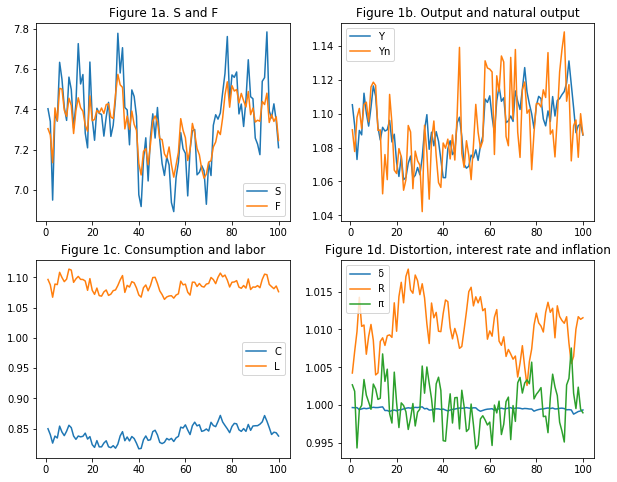

In [9]:
if "table" in sys.argv:
    build_paper_table()
else:
    results = main()